# 심층학습 [실습05] 합성곱 신경망(1)

### 201911019 최현민 - [GitHub url](https://github.com/hyunmin0317/DeepLearning)

### Load packages

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

### 1. MNIST train, test dataset 가져오기

In [2]:
# "": 현재 폴더에 MNIST 있음
# train 용으로 쓰겠다.
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
# test 용으로 쓰겠다.
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

### 2. 대략적인 데이터 형태

('mnist_train len:', 60000)
('mnist_test len:', 10000)
('image data shape:', torch.Size([1, 28, 28]))
('label: ', 5)


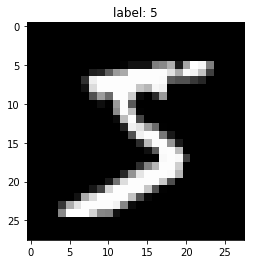

In [3]:
print("mnist_train len:", len(mnist_train))
print("mnist_test len:", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0)  # 0번째 데이터
print("image data shape:", image.size())
print("label: ", label)

# 그리기
img = image.numpy()  # image 타입을 numpy로 변환 (1,28,28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

### 3. MNIST data 띄워보기

5
torch.Size([1, 28, 28])
5


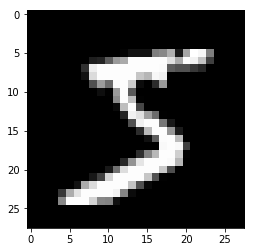

0


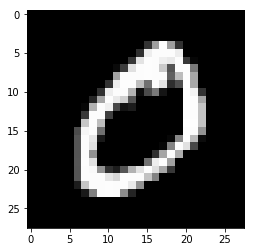

4


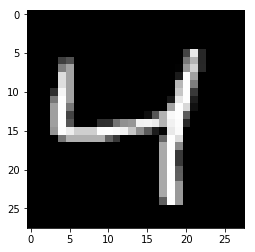

In [4]:
print(mnist_train[0][1])   # label
print(mnist_train[0][0].size())   # image

for i in range(3):
    img=mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0],cmap='gray')
    plt.show()

### 4. convolution 하나 씌워보기

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


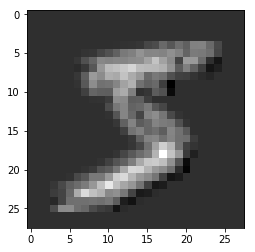

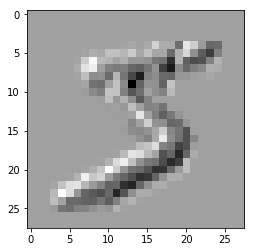

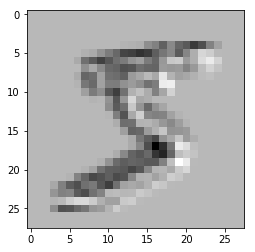

In [5]:
# mnist 의 첫 번째 이미지, 라벨 가져오기
image, label = mnist_train[0]
# view: tensor 의 사이즈 조절. -1: 해당 차원 차원 확장시켜라
# [1, 28, 28] -> [1, 1, 28, 28]
image=image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print(label)

# convolution filter 정의
conv_layer=nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
# image 에 filter 적용
output=conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0, i, :, :].data.numpy(), cmap='gray')
    plt.show()

### 5. CNN 만들기
* ### train, test data 가져오기

In [6]:
import numpy as np
import torch.optim as optim

batch_size = 16
learning_rate = 0.0002
num_epoch = 10   # 1000

In [7]:
# 후에 학습시킬 때 batch_size 단위로 학습시켜나감
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size=batch_size, 
                                           shuffle=True, num_workers=2,
                                           drop_last=True)  # batch_size 만큼 나눌 때 나머지는 버려라
# 후에 학습시킬 때 batch_size 단위로 학습시켜나감
test_loader = torch.utils.data.DataLoader((mnist_test), batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          drop_last=True)

### 6. CNN 클래스 만들기 (모델 만들기)

In [8]:
class CNN(nn.Module):   # nn.Module 상속받음
    def __init__(self):
        super(CNN, self).__init__()   # 28 * 28
        self.layer=nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),
            nn.ReLU(),
        
            nn.Conv2d(16, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 14*14 -> 7*7
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*7*7, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
   
    def forward(self, x):
        out=self.layer(x)
        out=out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

model = CNN()  #.cuda()

In [9]:
# 파라미터 체크하기
for parameter in model.parameters():
    # print(parameter)
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [10]:
# loss function, optimizer 선언
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 7. optimization

In [11]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader): # batch_size 만큼
        x = Variable(image)   #.cuda()
        y_ = Variable(label)  #.cuda()
        
        optimizer.zero_grad() # optimizer 안에서 이전 gradient 들을 초기화.
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()   # gradient 계산
        optimizer.step()  # parameter 업데이트
        
        if j%50==0:
            print(loss, j, i)

(tensor(2.3153, grad_fn=<NllLossBackward>), 0, 0)
(tensor(1.8322, grad_fn=<NllLossBackward>), 50, 0)
(tensor(0.7898, grad_fn=<NllLossBackward>), 0, 1)
(tensor(0.2740, grad_fn=<NllLossBackward>), 50, 1)
(tensor(0.2227, grad_fn=<NllLossBackward>), 0, 2)
(tensor(0.4845, grad_fn=<NllLossBackward>), 50, 2)
(tensor(0.0815, grad_fn=<NllLossBackward>), 0, 3)
(tensor(0.1961, grad_fn=<NllLossBackward>), 50, 3)
(tensor(0.3313, grad_fn=<NllLossBackward>), 0, 4)
(tensor(0.2131, grad_fn=<NllLossBackward>), 50, 4)
(tensor(0.4716, grad_fn=<NllLossBackward>), 0, 5)
(tensor(0.0030, grad_fn=<NllLossBackward>), 50, 5)
(tensor(0.0116, grad_fn=<NllLossBackward>), 0, 6)
(tensor(0.0180, grad_fn=<NllLossBackward>), 50, 6)
(tensor(0.3223, grad_fn=<NllLossBackward>), 0, 7)
(tensor(0.1301, grad_fn=<NllLossBackward>), 50, 7)
(tensor(0.0926, grad_fn=<NllLossBackward>), 0, 8)
(tensor(0.0744, grad_fn=<NllLossBackward>), 50, 8)
(tensor(0.0933, grad_fn=<NllLossBackward>), 0, 9)
(tensor(0.0768, grad_fn=<NllLossBackward>

In [12]:
try:
    # 미리 학습시킨 네트워크의 파라미터 집합 [피클]이라 발음함.
    model=torch.load('nets/mycnn_model_10.pkl')
    print("model restored")
except:
    print("model not restored")

model restored


In [13]:
def ComputeAcrr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):
        img = Variable(imgs)   #.cuda()   # x
        label = Variable(labels)   # y
        # label = Variable(labels).cuda()
        # .cuda() : GPU 에 로드되기 위함. 만약 CPU로 설정되어 있다면 에러남
        
        output = imodel.forward(img)  # forward prop.
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [14]:
ComputeAcrr(test_loader, model)

Accuracy of Test Data: 9.81000041962
